In [126]:
import numpy as np
import torch
import awkward as ak
import fastjet
import vector
import uproot
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from matplotlib.lines import Line2D
from dataclasses import dataclass
from torch.distributions.categorical import Categorical

vector.register_awkward()



class ParticleClouds:
    def __init__(self, 
                 dataset,
                 min_num_particles=0,
                 max_num_particles=128,
                 discrete_features=False):
        
        self.min_num_particles = min_num_particles
        self.max_num_particles = max_num_particles

        #...get particle data

        if isinstance(dataset, list):
            all_data = []
            for data in dataset:
                assert  '.root' in data, 'Input should be a path to a .root file or a tensor'
                data = self.read_root_file(data)
                features = ['part_pt', 'part_etarel', 'part_phirel', 'part_isChargedHadron', 'part_isNeutralHadron', 'part_isPhoton', 'part_isElectron', 'part_isMuon', 'part_charge', 'mask']       
                data = torch.tensor(np.stack([ak.to_numpy(self.pad(data[feat], min_num=min_num_particles, max_num=max_num_particles)) for feat in features] , axis=1))
                data = torch.permute(data, (0,2,1))    
                all_data.append(data)   
            data = torch.cat(all_data, dim=0)         
        else:
            assert isinstance(dataset, torch.Tensor), 'Input should be a path to a .root file or a tensor'
            data = dataset
        
        #...pt order data
        idx = torch.argsort(data[...,0], dim=1, descending=True)
        data_pt_sorted = torch.gather(data, 1, idx.unsqueeze(-1).expand(-1, -1, data.size(2)))
        
        #...get continuous features
        self.continuous = data_pt_sorted[...,:3]
        self.mask = data_pt_sorted[...,-1].long()
        self.pt = self.continuous[...,0] 
        self.eta = self.continuous[...,1]
        self.phi = self.continuous[...,2]
        self.multiplicity = torch.sum(self.mask, dim=1)

        #...get discrete features
        if discrete_features:
            self.isChargedHadron = data_pt_sorted[...,3]
            self.isNeutralHadron = data_pt_sorted[...,4]
            self.isPhoton = data_pt_sorted[...,5]
            self.isElectron = data_pt_sorted[...,6]
            self.isMuon = data_pt_sorted[...,7]
            self.flavor = torch.argmax(data_pt_sorted[...,3:8], dim=2)
            self.charge = data_pt_sorted[...,8]
            self.discrete = torch.concat([self.flavor.unsqueeze(dim=-1), self.charge.unsqueeze(dim=-1)], dim=2) 
        
    def __len__(self):
        return self.continuous.shape[0]
    
    def read_root_file(self, filepath):
        
        """Loads a single .root file from the JetClass dataset.
        """
        x = uproot.open(filepath)['tree'].arrays()
        x['part_pt'] = np.hypot(x['part_px'], x['part_py'])
        x['part_pt_log'] = np.log(x['part_pt'])
        x['part_ptrel'] = x['part_pt'] / x['jet_pt']
        x['part_deltaR'] = np.hypot(x['part_deta'], x['part_dphi'])

        p4 = vector.zip({'px': x['part_px'],
                         'py': x['part_py'],
                         'pz': x['part_pz'],
                         'energy': x['part_energy']})
        
        x['part_eta'] = p4.eta
        x['part_phi'] = p4.phi
        x['part_etarel'] = p4.eta - x['jet_eta'] 
        x['part_phirel'] = (p4.phi - x['jet_phi'] + np.pi) % (2 * np.pi) - np.pi
        x['mask'] = np.ones_like(x['part_energy']) 
        f = ak.concatenate([x['part_isChargedHadron'], x['part_isNeutralHadron'], x['part_isPhoton'], x['part_isElectron'], x['part_isMuon']], axis=1)
        x['flavor'] = ak.argmax(f, axis=1)
        return x

    def pad(self, a, min_num, max_num, value=0, dtype='float32'):
        assert max_num >= min_num, 'max_num must be >= min_num'
        assert isinstance(a, ak.Array), 'Input must be an awkward array'
        a = a[ak.num(a) >= min_num]
        a = ak.fill_none(ak.pad_none(a, max_num, clip=True), value)
        return ak.values_astype(a, dtype)

    def summary_stats(self):
        data = self.continuous[self.mask > 0]
        return {'mean': data.mean(0).numpy(),
                'std': data.std(0).numpy(),
                'min': data.min(0),
                'max': data.max(0)}
    
    def preprocess(self, scale=1.0):
        stats = self.summary_stats()
        self.continuous = (self.continuous - stats['mean']) / (stats['std'] * scale)
        self.pt = self.continuous[...,0] 
        self.eta = self.continuous[...,1]
        self.phi = self.continuous[...,2]

    def postprocess(self, stats, scale=1.0):
        self.continuous = (self.continuous * stats['std'] * scale) + stats['mean']
        self.pt = self.continuous[...,0] 
        self.eta = self.continuous[...,1]
        self.phi = self.continuous[...,2]

    def histogram(self, features='pt', num_bins=100, density=True, use_quantiles=False):
        mask = self.mask > 0
        x = getattr(self, features)[mask]
        bins = np.quantile(x, np.linspace(0.001, 0.999, num_bins)) if use_quantiles else num_bins
        return np.histogram(x, density=density, bins=bins)[0]

    def KLmetric1D(self, feature, reference, num_bins=100, use_quantiles=True):
        h1 = self.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        h2 = reference.constituents.histogram(feature, density=True, num_bins=num_bins, use_quantiles=use_quantiles) + 1e-8
        return scipy.stats.entropy(h1, h2)  

    def Wasserstein1D(self, feature, reference):
        mask = self.mask > 0
        x = getattr(self, feature)[mask]
        y = getattr(reference.constituents, feature)[mask]
        return scipy.stats.wasserstein_distance(x, y)

    def histplot(self, features='pt', xlim=None, ylim=None, xlabel=None, ylabel=None, idx=None, figsize=(3,3), ax=None, **kwargs):
        mask = self.mask > 0
        if ax is None: _, ax = plt.subplots(figsize=figsize)   
        if isinstance(features, tuple):
            x = getattr(self, features[0])[mask] if idx is None else getattr(self, features[0])[:,idx]
            y = getattr(self, features[1])[mask] if idx is None else getattr(self, features[1])[:,idx]
            sns.histplot(x=x, y=y, ax=ax, **kwargs)
            ax.set_xlabel(features[0] if xlabel is None else xlabel)
            ax.set_ylabel(features[1] if ylabel is None else ylabel)
        else:
            x = getattr(self, features)[mask] if idx is None else getattr(self, features)[:,idx]
            sns.histplot(x=x, element="step", ax=ax, **kwargs) 
            ax.set_xlabel(features if xlabel is None else xlabel)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def display_cloud(self, idx, ax=None, figsize=(3,3) , facecolor='whitesmoke', color='darkblue'):
            eta = self.eta[idx].numpy()
            phi = self.phi[idx].numpy()
            pt = self.pt[idx].numpy()
            mask = list(self.mask[idx].numpy()>0)
            pt = pt[mask] 
            eta = eta[mask] 
            phi = phi[mask] 

            if ax is None: _, ax = plt.subplots(figsize=figsize)            
            
            if hasattr(self, 'flavor'):

                flavor = self.flavor[idx].numpy()
                charge = self.charge[idx].numpy()
                flavor = flavor[mask]
                charge = charge[mask]

                ax.scatter(eta[(flavor==0) & (charge<0)], phi[(flavor==0) & (charge<0)], marker='^', s=3*pt[(flavor==0) & (charge<0)], color='darkblue', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==0) & (charge>0)], phi[(flavor==0) & (charge>0)], marker='v', s=3*pt[(flavor==0) & (charge>0)], color='darkblue', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[flavor==1], phi[flavor==1], marker='o', s=3*pt[flavor==1], color='darkred', alpha=0.5,  label=r'$h^{0}$')
                ax.scatter(eta[flavor==2], phi[flavor==2], marker='o', s=3*pt[flavor==2], color='gold', alpha=0.5, label=r'$\gamma$')
                ax.scatter(eta[(flavor==3) & (charge<0)], phi[(flavor==3) & (charge<0)], marker='^', s=3*pt[(flavor==3) & (charge<0)], color='green', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==3) & (charge>0)], phi[(flavor==3) & (charge>0)], marker='v', s=3*pt[(flavor==3) & (charge>0)], color='green', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==4) & (charge<0)], phi[(flavor==4) & (charge<0)], marker='^', s=3*pt[(flavor==4) & (charge<0)], color='purple', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==4) & (charge>0)], phi[(flavor==4) & (charge>0)], marker='v', s=3*pt[(flavor==4) & (charge>0)], color='purple', alpha=0.5,  label=r'$h^{\pm}$')

                # Define custom legend markers
                h1 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='darkblue', linestyle='None')
                h2 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='darkred', linestyle='None')
                h3 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='gold', linestyle='None')
                h4 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='green', linestyle='None')
                h5 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='purple', linestyle='None')

                plt.legend([h1, h2, h3, h4, h5], 
                        [r'$h^{\pm}$', r'$h^{0}$', r'$\gamma$', '$e^{\pm}$', '$\mu^{\pm}$'], 
                        loc="upper right", 
                        markerscale=2, 
                        scatterpoints=1, 
                        fontsize=7,  
                        frameon=False,
                        ncol=8,
                        bbox_to_anchor=(0.625, 1.11),
                        handletextpad=-0.5,  
                        columnspacing=.1) 
            else:
                ax.scatter(eta, phi, marker='o', s=3*pt, color=color, alpha=0.5)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor(facecolor)  # Set the same color for the axis background



In [175]:
tops = ParticleClouds(['/home/df630/CMB/data/JetClass/TTBar_000.root'], min_num_particles=0, max_num_particles=30, features_discrete=True)
noise = NoiseClouds(num_clouds=100000, max_num_particles=30, features_discrete=True, masks_like=tops)

(tensor(30), tensor(16), tensor(30), tensor(15))

/tmp/ipykernel_228833/1983072608.py:155: RuntimeWarning: divide by zero encountered in log
  pt = 10 * np.log(self.pt[idx].numpy())
/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


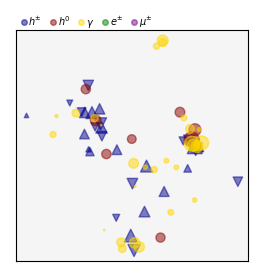

In [135]:
tops.display_cloud(0)

In [145]:
tops.multiplicity.max()

tensor(100)

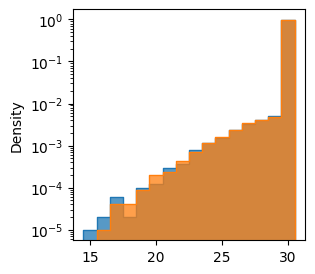

In [177]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
sns.histplot(tops.multiplicity, element="step", discrete=True,  ax=ax, stat='density', log_scale=(False, True))
sns.histplot(noise.multiplicity, element="step", discrete=True,  ax=ax, stat='density', log_scale=(False, True))
plt.show()

In [171]:
class NoiseClouds:
    def __init__(self, 
                num_clouds, 
                max_num_particles=128,
                masks_like=None,
                features_discrete=False):
                
        self.num_clouds = num_clouds
        self.max_num_particles = max_num_particles 

        continuous = torch.randn((num_clouds, max_num_particles, 3))
        idx = torch.argsort(continuous[...,0], dim=1, descending=True)
        self.continuous = torch.gather(continuous, 1, idx.unsqueeze(-1).expand(-1, -1, continuous.size(2)))
        self.pt = self.continuous[...,0] 
        self.eta = self.continuous[...,1]
        self.phi = self.continuous[...,2]
        self.sample_masks(masks_like=masks_like)
        # self.multiplicity = torch.sum(self.mask, dim=1)

        if features_discrete:
            flavor = np.random.choice([0,1,2,3,4], size=(num_clouds, max_num_particles))
            charge = np.random.choice([-1, 1], size=(num_clouds, max_num_particles))
            charge = np.where((flavor==1) | (flavor==2), 0, charge)
            self.flavor = torch.tensor(flavor).long()
            self.charge = torch.tensor(charge).long()
            self.discrete = torch.concat([self.flavor.unsqueeze(dim=-1), self.charge.unsqueeze(dim=-1)], dim=2)

            self.isChargedHadron = torch.zeros((num_clouds, max_num_particles))
            self.isNeutralHadron = torch.zeros((num_clouds, max_num_particles))
            self.isPhoton = torch.zeros((num_clouds, max_num_particles))
            self.isElectron = torch.zeros((num_clouds, max_num_particles))
            self.isMuon = torch.zeros((num_clouds, max_num_particles))

            self.isChargedHadron[self.flavor==0] = 1
            self.isNeutralHadron[self.flavor==1] = 1
            self.isPhoton[self.flavor==2] = 1
            self.isElectron[self.flavor==3] = 1
            self.isMuon[self.flavor==4] = 1

    def __len__(self):
        return self.num_clouds 

    def sample_masks(self, masks_like=None):
        ''' Sample masks from a multiplicity distribution of target 'masks_like'.
        '''
        if masks_like is None:
            # If no reference histogram is provided, use full masks
            self.mask = torch.ones_like(self.pt)
        else:
            max_val = masks_like.max_num_particles
            hist_values, bin_edges = np.histogram(masks_like.multiplicity, bins=np.arange(0, max_val + 2, 1), density=True)
            bin_edges[0] = np.floor(bin_edges[0])   # Ensure lower bin includes the floor of the lowest value
            bin_edges[-1] = np.ceil(bin_edges[-1])  # Extend the upper bin edge to capture all values
            
            histogram = torch.tensor(hist_values, dtype=torch.float)
            probs = histogram / histogram.sum()
            cat = Categorical(probs)
            self.multiplicity = cat.sample((len(self),))  
            
            # Initialize masks and apply the sampled multiplicities
            masks = torch.zeros((len(self), self.max_num_particles))
            for i, n in enumerate(self.multiplicity):
                masks[i, :n] = 1  
            self.mask = masks.long()

    def histplot(self, features='pt', xlim=None, ylim=None, xlabel=None, ylabel=None, idx=None, figsize=(3,3), ax=None, **kwargs):
        mask = self.mask > 0
        if ax is None: _, ax = plt.subplots(figsize=figsize)   
        if isinstance(features, tuple):
            x = getattr(self, features[0])[mask] if idx is None else getattr(self, features[0])[:,idx]
            y = getattr(self, features[1])[mask] if idx is None else getattr(self, features[1])[:,idx]
            sns.histplot(x=x, y=y, ax=ax, **kwargs)
            ax.set_xlabel(features[0] if xlabel is None else xlabel)
            ax.set_ylabel(features[1] if ylabel is None else ylabel)
        else:
            x = getattr(self, features)[mask] if idx is None else getattr(self, features)[:,idx]
            sns.histplot(x=x, element="step", ax=ax, **kwargs) 
            ax.set_xlabel(features if xlabel is None else xlabel)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

    def summary_stats(self):
        data = self.continuous
        return {'mean': data.mean(0).numpy(),
                'std': data.std(0).numpy(),
                'min': data.min(0),
                'max': data.max(0)}

    def display_cloud(self, idx, ax=None, figsize=(3,3) , facecolor='whitesmoke', color='darkblue'):
            eta = self.eta[idx].numpy()
            phi = self.phi[idx].numpy()
            pt = 10*self.pt[idx].numpy()
            mask = list(self.mask[idx].numpy()>0)
            pt = pt[mask] 
            eta = eta[mask] 
            phi = phi[mask] 

            if ax is None: _, ax = plt.subplots(figsize=figsize)            
            
            if hasattr(self, 'flavor'):

                flavor = self.flavor[idx].numpy()
                charge = self.charge[idx].numpy()
                flavor = flavor[mask]
                charge = charge[mask]

                ax.scatter(eta[(flavor==0) & (charge<0)], phi[(flavor==0) & (charge<0)], marker='^', s=3*pt[(flavor==0) & (charge<0)], color='darkblue', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==0) & (charge>0)], phi[(flavor==0) & (charge>0)], marker='v', s=3*pt[(flavor==0) & (charge>0)], color='darkblue', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[flavor==1], phi[flavor==1], marker='o', s=3*pt[flavor==1], color='darkred', alpha=0.5,  label=r'$h^{0}$')
                ax.scatter(eta[flavor==2], phi[flavor==2], marker='o', s=3*pt[flavor==2], color='gold', alpha=0.5, label=r'$\gamma$')
                ax.scatter(eta[(flavor==3) & (charge<0)], phi[(flavor==3) & (charge<0)], marker='^', s=3*pt[(flavor==3) & (charge<0)], color='green', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==3) & (charge>0)], phi[(flavor==3) & (charge>0)], marker='v', s=3*pt[(flavor==3) & (charge>0)], color='green', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==4) & (charge<0)], phi[(flavor==4) & (charge<0)], marker='^', s=3*pt[(flavor==4) & (charge<0)], color='purple', alpha=0.5,  label=r'$h^{\pm}$')
                ax.scatter(eta[(flavor==4) & (charge>0)], phi[(flavor==4) & (charge>0)], marker='v', s=3*pt[(flavor==4) & (charge>0)], color='purple', alpha=0.5,  label=r'$h^{\pm}$')

                # Define custom legend markers
                h1 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='darkblue', linestyle='None')
                h2 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='darkred', linestyle='None')
                h3 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='gold', linestyle='None')
                h4 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='green', linestyle='None')
                h5 = Line2D([0], [0], marker='o', markersize=2, alpha=0.5, color='purple', linestyle='None')

                plt.legend([h1, h2, h3, h4, h5], 
                        [r'$h^{\pm}$', r'$h^{0}$', r'$\gamma$', '$e^{\pm}$', '$\mu^{\pm}$'], 
                        loc="upper right", 
                        markerscale=2, 
                        scatterpoints=1, 
                        fontsize=7,  
                        frameon=False,
                        ncol=8,
                        bbox_to_anchor=(0.625, 1.11),
                        handletextpad=-0.5,  
                        columnspacing=.1) 
            else:
                ax.scatter(eta, phi, marker='o', s=3*pt, color=color, alpha=0.5)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_facecolor(facecolor)  # Set the same color for the axis background



In [178]:
class JetClassDataClass:
    def __init__(self, config: dataclass, discrete_features: bool=False, standardize: bool=False):
        self.config = config

        if config.target == 'tops':
            self.target = ParticleClouds(config.path, min_num_particles=config.min_num_particles, max_num_particles=config.max_num_particles, features_discrete=discrete_features)
            if standardize: self.target.preprocess()
            
        if config.source == 'noise':
            self.source = NoiseClouds(num_clouds=len(self.target), max_num_particles=config.max_num_particles, features_discrete=discrete_features, masks_like=self.target)



In [180]:
from dataclasses import dataclass, field
from typing import List

@dataclass
class Config:
    #...general params:
    workdir = './'   
    device = 'cuda:0'
    multi_gpu  = False

    #...data params:
    path = ['/home/df630/CMB/data/JetClass/TTBar_000.root', '/home/df630/CMB/data/JetClass/TTBar_000.root']
    source ='noise'
    target = 'tops'
    min_num_particles = 0
    max_num_particles = 128

config = Config()
jets = JetClassDataClass(config, discrete_features=True, standardize=True)


/tmp/ipykernel_228833/1983072608.py:155: RuntimeWarning: invalid value encountered in log
  pt = 10 * np.log(self.pt[idx].numpy())
/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


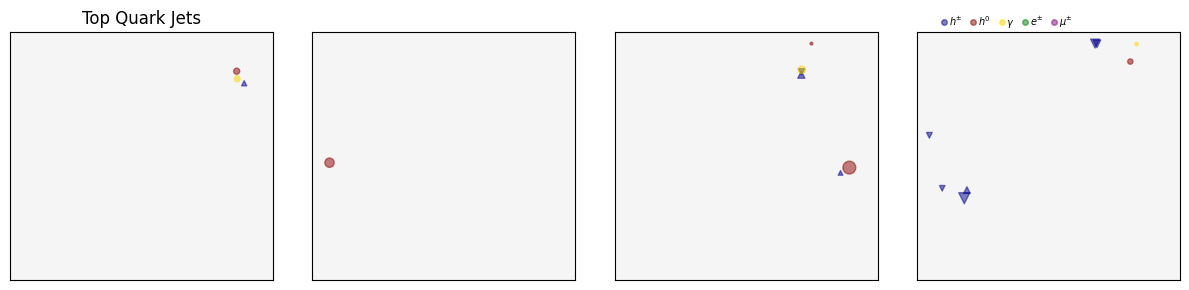

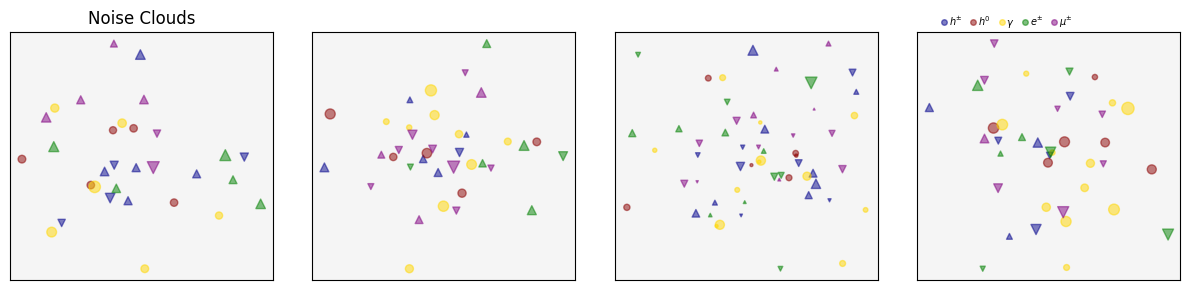

In [181]:
fig, ax = plt.subplots(1, 4, figsize=(12,3)) 
jets.target.display_cloud(idx=0, ax=ax[0])
jets.target.display_cloud(idx=1, ax=ax[1])
jets.target.display_cloud(idx=2, ax=ax[2])
jets.target.display_cloud(idx=3, ax=ax[3])
ax[0].set_title('Top Quark Jets')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 4, figsize=(12,3)) 
jets.source.display_cloud(idx=0, ax=ax[0])
jets.source.display_cloud(idx=1, ax=ax[1])
jets.source.display_cloud(idx=2, ax=ax[2])
jets.source.display_cloud(idx=3, ax=ax[3])
ax[0].set_title('Noise Clouds')
plt.tight_layout()
plt.show()


<Axes: ylabel='Density'>

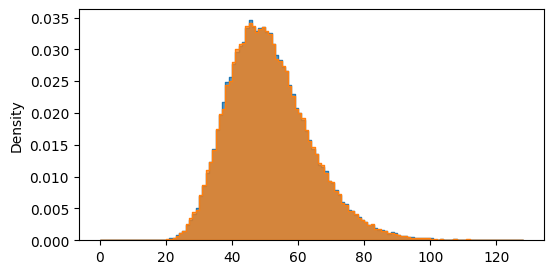

In [188]:
fig,ax = plt.subplots(figsize=(6,3))
sns.histplot(jets.target.multiplicity, element='step', binrange=(0, 128), binwidth=1, stat='density', ax=ax)
sns.histplot(jets.source.multiplicity, element='step', binrange=(0,128), binwidth=1, stat='density', ax=ax)
# sns.histplot(jets.source.mask.sum(1), element='step', fill=False,binrange=(0,128), binwidth=1, ls='--', color='k', stat='density', ax=ax)

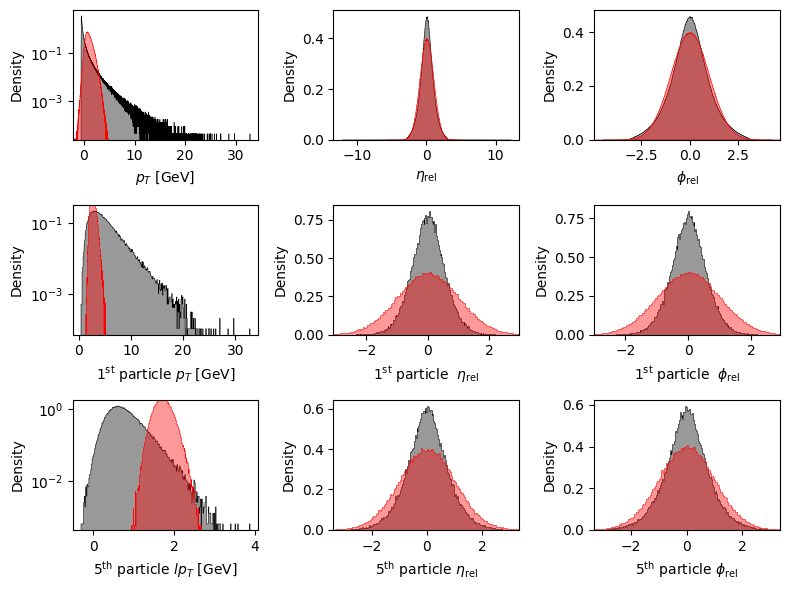

In [190]:
_, ax = plt.subplots(nrows=3, ncols=3, figsize=(8,6))

plot_args_0 = {'alpha': 0.4,
             'lw': 0.4, 
             'log_scale': (False, True), 
             'stat': 'density'}

plot_args_1 = {'alpha': 0.4,
             'lw': 0.4, 
             'log_scale': (False, False), 
             'stat': 'density'}

jets.target.histplot('pt', xlabel=r'$p_T$ [GeV]',  ax=ax[0,0], label='top', color='k', **plot_args_0)
jets.source.histplot('pt', xlabel=r'$p_T$ [GeV]',  ax=ax[0,0], label='top', color='r', **plot_args_0)
jets.target.histplot('eta', xlabel=r'$\eta_{\rm rel}$', binwidth=0.02, ax=ax[0,1], color='k', **plot_args_1)
jets.source.histplot('eta', xlabel=r'$\eta_{\rm rel}$',  ax=ax[0,1], label='top', color='r', **plot_args_1)
jets.target.histplot('phi', xlabel=r'$\phi_{\rm rel}$', binwidth=0.02, ax=ax[0,2], color='k', **plot_args_1)
jets.source.histplot('phi', xlabel=r'$\phi_{\rm rel}$',  ax=ax[0,2], label='top', color='r', **plot_args_1)

jets.target.histplot('pt', idx=0, xlabel=r'1$^{\rm st}$ particle $p_T$ [GeV]', color='k', ax=ax[1,0], **plot_args_0)
jets.source.histplot('pt',  idx=0, xlabel=r'1$^{\rm st}$ particle $p_T$ [GeV]',  ax=ax[1,0], label='top', color='r', **plot_args_0)
jets.target.histplot('eta', idx=0, xlabel=r'1$^{\rm st}$ particle  $\eta_{\rm rel}$', color='k', ax=ax[1,1], **plot_args_1)
jets.source.histplot('eta', idx=0, xlabel=r'1$^{\rm st}$ particle  $\eta_{\rm rel}$', color='r', ax=ax[1,1], **plot_args_1)
jets.target.histplot('phi', idx=0, xlabel=r'1$^{\rm st}$ particle  $\phi_{\rm rel}$', color='k',  ax=ax[1,2], **plot_args_1)
jets.source.histplot('phi', idx=0, xlabel=r'1$^{\rm st}$ particle  $\phi_{\rm rel}$', color='r', ax=ax[1,2], **plot_args_1)

jets.target.histplot('pt', idx=5, xlabel=r'5$^{\rm th}$ particle $lp_T$ [GeV]', color='k', ax=ax[2,0], **plot_args_0)
jets.source.histplot('pt', idx=5, xlabel=r'5$^{\rm th}$ particle $lp_T$ [GeV]',  ax=ax[2,0], label='top', color='r', **plot_args_0)
jets.target.histplot('eta', idx=5, xlabel=r'5$^{\rm th}$ particle $\eta_{\rm rel}$', color='k', ax=ax[2,1], **plot_args_1)
jets.source.histplot('eta', idx=5, xlabel=r'5$^{\rm th}$ particle $\eta_{\rm rel}$', color='r', ax=ax[2,1], **plot_args_1)
jets.target.histplot('phi', idx=5, xlabel=r'5$^{\rm th}$ particle $\phi_{\rm rel}$', color='k', ax=ax[2,2], **plot_args_1)
jets.source.histplot('phi', idx=5, xlabel=r'5$^{\rm th}$ particle $\phi_{\rm rel}$', color='r', ax=ax[2,2], **plot_args_1)

plt.tight_layout()

In [61]:
np.arange(0, 30+1, 1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])